## Project setup

Before we get started with any project, it is a good idea to create a [virtual environment](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended) to isolate project-specific libraries from the global environment. Python virtual environment stores dependencies required by different projects in separate places by creating virtual environments for them. It solves the “Project X depends on TensorFlow version 1.x but Project Y needs 2.x version” dilemma and keeps your global site-packages directory clean and manageable. Create a new virtual environment by running the following commands:

```bash
virtualenv -p python3.7 .env        # create a virtual environment (python3.7)
source .env/bin/activate            # activate the virtual environment
pip3 install -r requirements.txt    # install dependencies
deactivate                          # exit the virtual environment 

```

requirements.txt can be found [here](https://github.com/adelekuzmiakova/food-security-detecting-disease/blob/master/requirements.txt).

## Image classification

Image classification is the core task in computer vision. The goal of an image classification task is to read an image and **assign one label from a fixed set of categories to it**. Despite its simplicity, image classification has many applications in machine learning, web development, or data science. Additionally, many other computer vision problems, such as object detection or semantic segmentation, can be reduced to image classification.

This tutorial shows how to classify images of bean plants into 3 categories:

1. **Angular Leaf Spot disease** (label: 0)
2. **Bean Rust disease** (label: 1)
3. **Healthy** (label: 2)

![Alt text](assets/3classes.png?raw=true "3 Classes")


In this tutorial we will follow a standard machine learning workflow:

1. Examine the data and build an input pipeline 
2. Build the classification model
3. Train the model
4. Test the model, evaluate its performance, and fine-tune hyperparameters


### Step 1: Examine the data and build an input pipeline

We start with importing necessary libraries:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
%matplotlib inline
%load_ext tensorboard
!rm -rf ./logs/ 

`TFDS` module provides a collection of ready-to-use datasets. In this example, we will be working with `beans` [dataset](https://github.com/AI-Lab-Makerere/ibean), where each image contains bean plants grown on small farms in East Africa. Beans are a staple in many East African cousines and represent a significant source of protein for school-aged children. 
Our goal is to help diagnose the health condition of bean crops and **develop a classifier that can predict whether the bean leaves have been affected by a disease or not**. Every image in this dataset is 500-by-500 pixels large and was taken by a smartphone camera on the farm. Also, every image is associated with exactly one condition (healthy, angular leaf spot disease, or bean rust disease). The training, validation, and test sets contain 1034, 133 and 128 images, respectively. 

Also, you can see a list of all datasets registered on TensorFlow [here](https://www.tensorflow.org/datasets/catalog/overview) or by using `tfds.list_builders()` method.

In [2]:
# Enable eager execution
#tf.enable_v2_behavior()

# Check out all available datasets 
#tfds.list_builders()

We load the data with the following arguments:

1. `name`: name of the dataset, can be obtained from `tfds.list_builders()`
2. `split`: indicates which split of the data to load
3. `as_supervised`: if `True`, then it returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`
4. `with_info`: if `True`, it will return a tuple containing the information associated with the dataset builder

In [38]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name = 'beans', 
    split = ['train', 'validation', 'test'],
    as_supervised = True,
    with_info = True)
#print(ds_info)

We can build the training pipeline using the following transformations:
1. `ds_train.map`: applies normalization because TFDS returns images in unit8 format while the model requires float32 format. Additionally, it resizes images given the target height and width.
2. `ds_train.cache`: caches before shuffling 
3. `ds_train.shuffle`: shuffles the training example to ensure randomness and prevent potential class imbalance
4. `ds_train.batch`: splits the examples into batches
5. `ds_train.prefetch`: overlaps the preprocessing and model execution work

In [39]:
# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32


# Let's keep the dimensions the same (no resizing for now)

def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label

ds_train = ds_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

Similarly, we can build the validation and test pipeline using similar transformations as above. The main difference is that now all the batches can be the same during each epoch so we don't shuffle the examples. Also, caching is now done after batching.

In [40]:
ds_validation = ds_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Now that we have a input pipeline ready, we can examine the data more closely. Specifically, it is a good idea to check for **class imbalance** and see whether there is a class (*healthy*, *angular leaf spot disease*, or *bean rust disease*) that contains significantly fewer samples than other classes. If yes, that might be a problem for the deep learning model. But let's confirm that first:

In [41]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

In [42]:
training_labels = return_class_labels(ds_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(ds_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))
      
test_labels = return_class_labels(ds_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


Great, we see that all classes are evenly represented in train, validation, and test set. Now let's plot some of the images to see what they look like:

In [7]:
example = ds_train.take(1)
for sample in example:
    image, label = sample[0], sample[1]
    image = image.numpy()
    label = label.numpy()

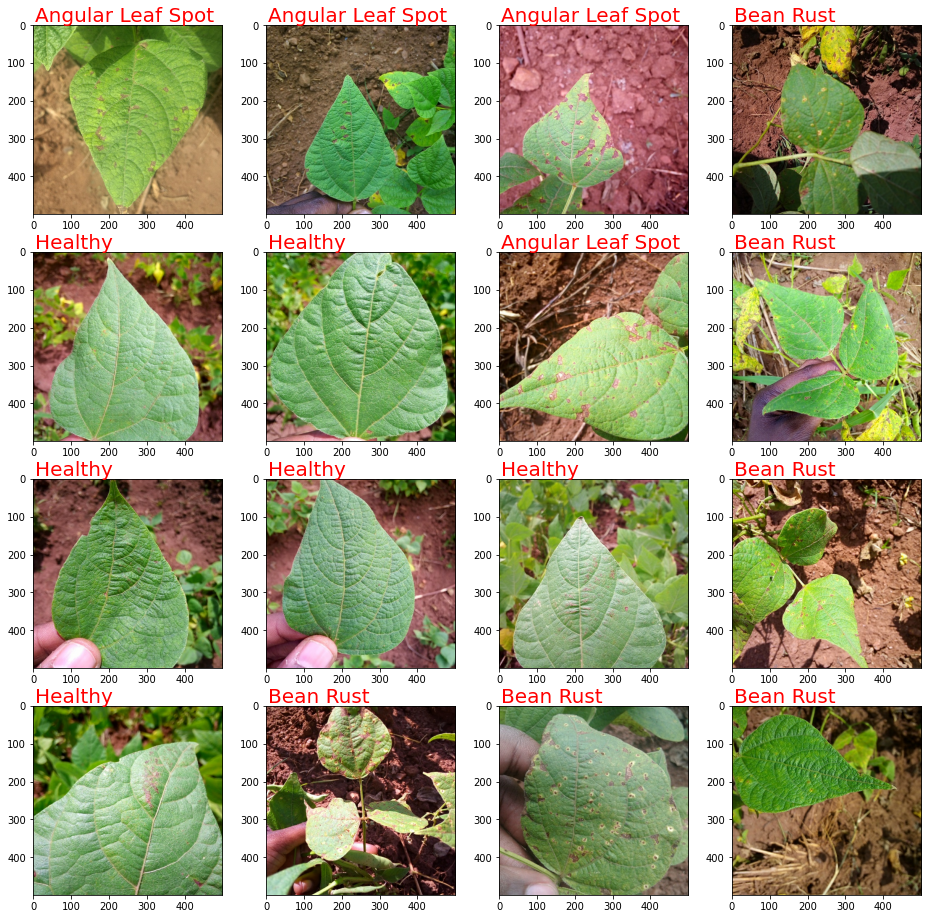

In [11]:
n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))

### Step 2: Build the classification model

One of the most popular ways to build a deep learning model is using Keras [Sequential](https://keras.io/getting-started/sequential-model-guide/) class. Here `Sequential` represents a linear stack of network layers. It is very easy to construct layers by using the `.add()` method. In our stack we will start with 4 basic layers: **Convolutional**, **Pooling**, **Dropout**, and **Dense**.

* **Convolutional:** will create a feature map by convolving an input (image) with a filter
* **Pooling:** will perform downsampling along the specific dimension
* **Dropout:** will ignore the fraction of units during training to prevent overfitting
* **Dense:** will perform a linear operation on the input vector. Also known as *fully-connected* layer.

In [43]:
# Set the hyperparameters:
num_filters = 15
filter_size = 10
pool_size = 4
strides = 2
fc_output = 128
drop_probability = 0.30
learning_rate = 0.001


def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(num_filters, filter_size, input_shape = (image_height, image_width, num_channels),
                        strides = strides, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = pool_size),
    tf.keras.layers.Dropout(drop_probability),
    tf.keras.layers.Conv2D(num_filters, filter_size, strides = strides, padding = 'same', 
                         activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = pool_size),
    tf.keras.layers.Dropout(drop_probability),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc_output, activation = 'relu'),
    tf.keras.layers.Dense(num_classes, activation = 'softmax'),
])

We can see the model summary together with output shapes after each layer by using `model.summary()`.

Now we are ready to compile our model with the following parameters:
1. `loss`: the output of the last layer is a softmax classifier, which gives normalized class probabilities that add up to 1. Therefore, we will use cross-entropy loss for the softmax output. There are 2 kinds of cross-entropy loss: **binary cross-entropy** when number of classes = 2 and **categorical cross-entropy** when number of classes > 2. We'll choose the second option.
2. `optimizer`: **Adam** is probably the most widely used optimizer although other choices include stochastic gradient descent (SGD). 
3. `learning rate`: this is a very important hyper-parameter of the deep learning model. It tells us how quickly the optimizing function is moving towards the minimum of the loss function. Higher learning will converge faster but may also become unstable. Smaller learning rate is more stable but progress may be slow. Generally, when fine-tuning learning rates, there is a log search space: [$10^{-4}$, $10^{-3}$, $10^{-2}$, $10^{-1}$, $10^{0}$].
4. `metrics`: this function characterizes how well our model is predicting class labels. The choice of the metric function should be similar to the loss function. Since we are using binary cross-entropy loss, we can use **accuracy** as our metric. 

In [44]:
model = create_model()
model.summary()
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy'],
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 250, 250, 15)      4515      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 15)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 15)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 31, 15)        22515     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 15)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 15)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 735)              

### Step 3: Train the model

The learning algorithm will go through each training batch exactly once during one **epoch**. At the end of each epoch, it will also evaluate its performance on the validation set. Remember, the size of the training set is 1034 images and each batch contains 32 example, so we'll have 33 batches to go through in each epoch. For now, we set the number of epochs to 20 although in practice the model should be stopped when accuracy and loss has has plateaud. We should see the training and validation loss go down with each epoch.

In [45]:
num_epochs = 25

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = 0)


history = model.fit(
    ds_train,
    epochs = num_epochs,
    verbose = 0,
    callbacks=[tensorboard_callback],
    validation_data = ds_validation,
)

Epoch 1/25
33/33 [==============================] - 74s 2s/step - loss: 1.0747 - accuracy: 0.3936 - val_loss: 1.0534 - val_accuracy: 0.3308
Epoch 2/25
33/33 [==============================] - 66s 2s/step - loss: 0.9622 - accuracy: 0.5406 - val_loss: 0.8394 - val_accuracy: 0.6015
Epoch 3/25
33/33 [==============================] - 71s 2s/step - loss: 0.8744 - accuracy: 0.6006 - val_loss: 0.8857 - val_accuracy: 0.5940
Epoch 4/25
33/33 [==============================] - 70s 2s/step - loss: 0.8588 - accuracy: 0.5938 - val_loss: 0.7538 - val_accuracy: 0.6466
Epoch 5/25
33/33 [==============================] - 73s 2s/step - loss: 0.8569 - accuracy: 0.6093 - val_loss: 0.7383 - val_accuracy: 0.6466
Epoch 6/25
33/33 [==============================] - 74s 2s/step - loss: 0.7789 - accuracy: 0.6576 - val_loss: 0.7504 - val_accuracy: 0.6391
Epoch 7/25
33/33 [==============================] - 72s 2s/step - loss: 0.8186 - accuracy: 0.6248 - val_loss: 0.8013 - val_accuracy: 0.5940
Epoch 8/25
33/33 [==

Here we plot the the training and validation accuracy and loss for each epoch:

In [46]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 3421), started 4 days, 2:57:29 ago. (Use '!kill 3421' to kill it.)

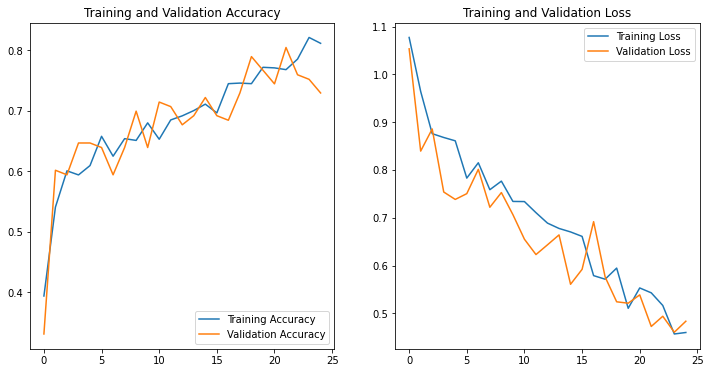

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Step 4: Test the model, evaluate its performance, and fine-tune hyperparameters

In the end, we also want to evaluate our model on the test set, which hasn't been seen during the training process. It's a good chance to test our model on the independent data set to gauge how it could perform on unseen data. 

In [48]:
test_loss, test_acc = model.evaluate(ds_test)
print('\n Final test accuracy:', test_acc)


      4/Unknown - 2s 410ms/step - loss: 0.5959 - accuracy: 0.7656
 Final test accuracy: 0.765625


83.5% accuracy on the test set is not a bad outcome given this simple network. It is also a good idea to compare actual and predicted class labels from the test set to see if there is any kind of bias towards specific image features. Remember that the softmax output is normalized class probabilities so to get the most probable label for each image we have to apply `argmax()` function on the softmax output across rows (`axis = 1`):

In [49]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
normalized_probs = probability_model.predict(ds_test)
predicted_labels = np.argmax(normalized_probs, axis = 1)
actual_labels = return_class_labels(ds_test)

# Looking at test images
example = ds_test.take(1)
for sample in example:
    image = sample[0]
    image = image.numpy()


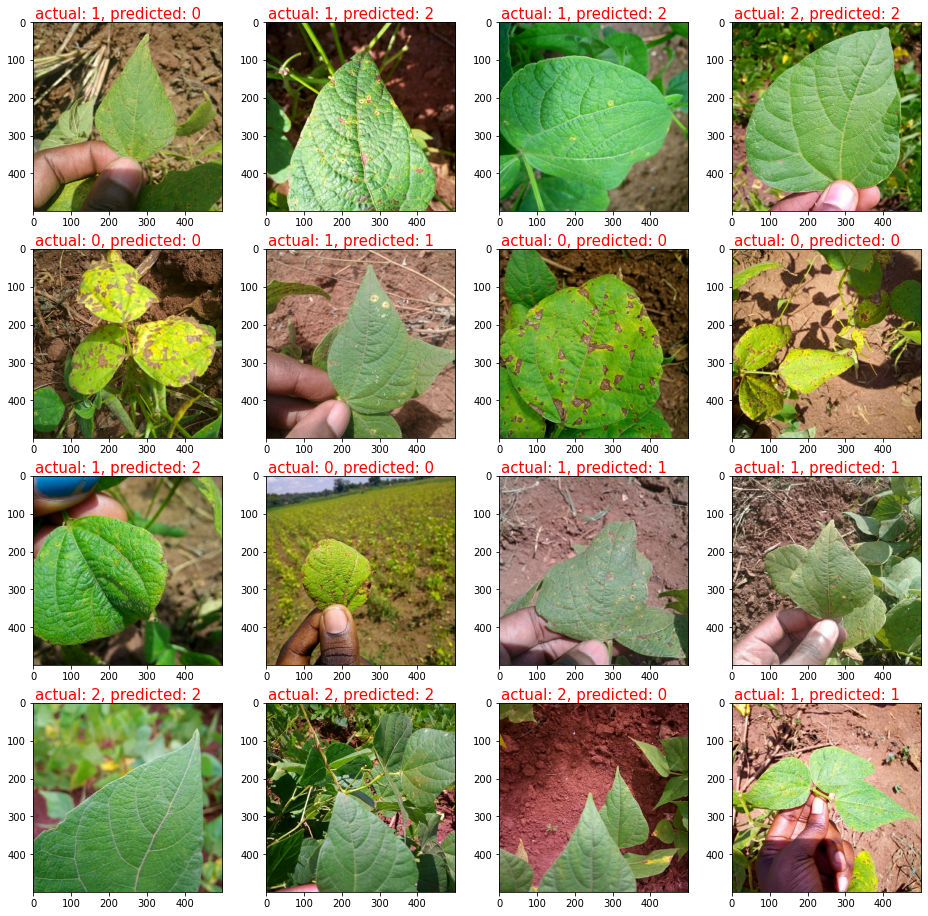

In [50]:
n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "actual: " + str(actual_labels[i]) + ", predicted: " + str(predicted_labels[i]) ,
            color = 'red', fontsize = 15)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))

In most cases the network outputs the correct label which is still very impressive given its simple architecture. The second-to-last example was misclassified because the actual label is 2 (healthy) whereas the predicted label is 1 (bean rust disease). That makes sense because although the front leaf close to the camera is healthy, the leaves in the background appear to have some yellow patches and normally could be classified as having disease.

To achieve higher accuracy, there are many more aspects we could experiment with:

* **Data augmentation**: applies geometric transformations, such as scaling, cropping, to training images in order to add diversity and increase the size of the training set.

* **Adding or removing layers in the architecture**

* **Fine-tuning the hyper-parameters**: especially the learning rate, batch size, number of filters